Проект по семантической сегментации раковых опухолей.

* имплементация SegNet и UNet с нуля. (метрика - IoU)

  * сравнение различных кастомных лосс - функций для обучения ( bce_loss, dice_loss, focal_loss, + custom_loss)

  * для различных лоссов проведено сравнение и сделаны выводы о том, что лучше использовать

* два варианта имплементации U-net

  1. Downsample with MaxPool

      Upsample - nn.Upsample

  2. Downsample with no MaxPool, only Conv layers

      Upsample - ConvTranspose2d


* проведено сравнение как лоссов внутри самих моделей, так и между моделями


#### спойлер

лучшая архитектура - U-net-2 с кастомным лоссом

# Imports

In [ ]:
import os
import pandas as pd
from skimage.io import imread
import os
import numpy as np
from skimage.transform import resize
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from torch.nn.modules.pooling import MaxPool2d

import torchvision.transforms.functional as fn
from torchvision.transforms import CenterCrop




# Download Dataset

---


1.  [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>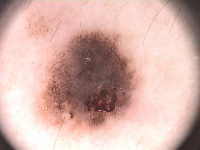</td><td>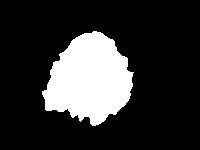</td></tr></table>

2. Разархивируем .rar файл.


In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


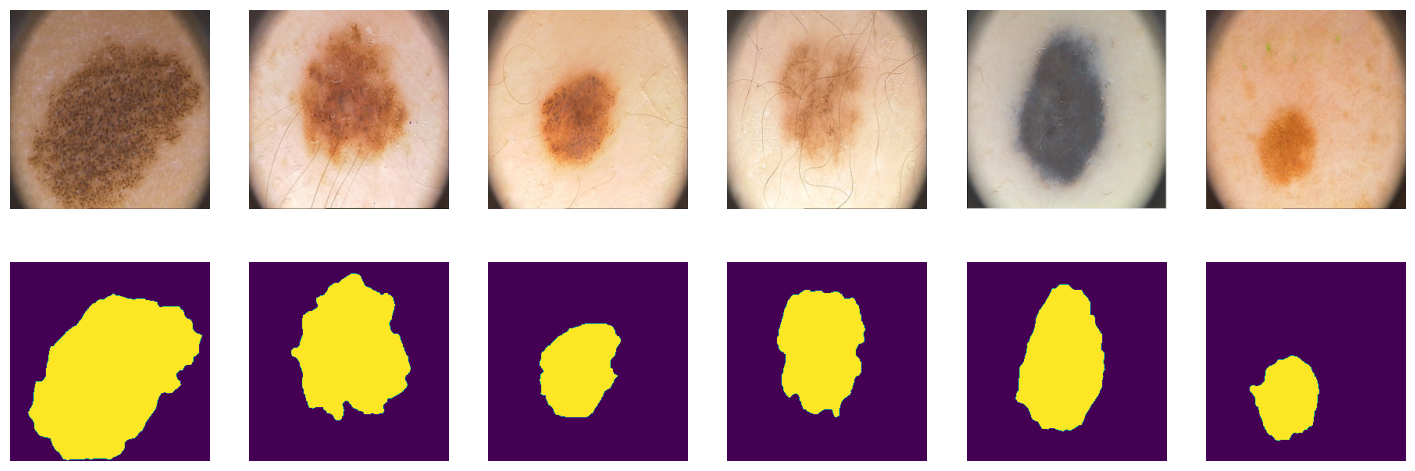

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


# PyTorch DataLoader

In [ ]:
batch_size = 4
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Compare several architectures

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

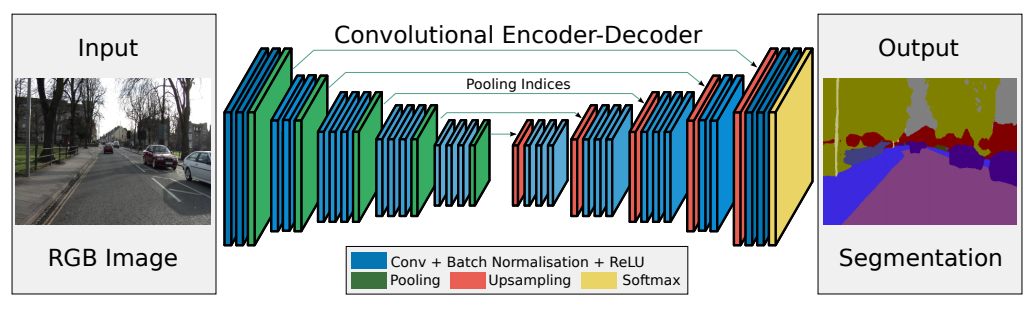

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

## SegNet architecture

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 16*2 , (3, 3)  , stride=(1, 1),  padding=1),
                  nn.BatchNorm2d(16*2),
                  nn.ReLU(),
                  nn.Conv2d(16*2,16*2 , (3, 3) , stride=(1, 1), padding=1 ),
                  nn.BatchNorm2d(16*2),
                  nn.ReLU()

          )


        # 256 -> 128
        self.pool0 = nn.MaxPool2d((2, 2), return_indices=True)
        self.enc_conv1 = nn.Sequential(
              nn.Conv2d(16*2, 32*2 , (3, 3) , stride=(1, 1), padding=1 ),
                  nn.BatchNorm2d(32*2),
                  nn.ReLU(),

                  nn.Conv2d(32*2,32*2 , (3, 3) ,stride=(1, 1),  padding=1 ),
                  nn.BatchNorm2d(32*2),
                  nn.ReLU(),

          )

        self.pool1 =   nn.MaxPool2d((2, 2), return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
              nn.Conv2d(32*2, 64*2 , (3, 3) ,  stride=(1, 1),padding=1 ),
                  nn.BatchNorm2d(64*2),
                  nn.ReLU(),
                  nn.Conv2d(64*2,64*2 , (3, 3) ,stride=(1, 1),  padding=1 ),
                  nn.BatchNorm2d(64*2),
                  nn.ReLU(),
                  nn.Conv2d(64*2,64*2 , (3, 3) , stride=(1, 1), padding=1 ),
                  nn.BatchNorm2d(64*2),
                  nn.ReLU()
          )
        self.pool2 = nn.MaxPool2d((2, 2), return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(

              nn.Conv2d(64*2, 128*2 , (3, 3)  ,stride=(1, 1),  padding=1),
                  nn.BatchNorm2d(128*2),
                  nn.ReLU(),
                  nn.Conv2d(128*2,128*2 , (3, 3) , stride=(1, 1), padding=1 ),
                  nn.BatchNorm2d(128*2),
                  nn.ReLU(),
                  nn.Conv2d(128*2,128*2 , (3, 3) ,  stride=(1, 1),padding=1 ),
                  nn.BatchNorm2d(128*2),
                  nn.ReLU()

          )



        self.pool3 =  nn.MaxPool2d((2, 2), return_indices=True)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv_0 = nn.Sequential(

             nn.Conv2d(128*2, 256*2 , (3, 3) , stride=(1, 1), padding=1),
              nn.BatchNorm2d(256*2),
              nn.ReLU(),
              nn.Conv2d(256*2,256*2 , (3, 3)  ,stride=(1, 1),  padding=1),
              nn.BatchNorm2d(256*2),
              nn.ReLU(),
              nn.Conv2d(256*2,256*2 , (3, 3)  ,stride=(1, 1),  padding=1),
              nn.BatchNorm2d(256*2),
              nn.ReLU()

        )

        # ------------------------
        self.bottleneck_0 = nn.MaxPool2d((2, 2), return_indices=True)
        self.bottleneck_1 = nn.MaxUnpool2d((2, 2))
        # ------------------------


        self.bottleneck_conv_1 =nn.Sequential(

             nn.Conv2d(256*2, 256*2 , (3, 3) , stride=(1, 1), padding=1 ),
              nn.BatchNorm2d(256*2),
              nn.ReLU(),
              nn.Conv2d(256*2,256*2 , (3, 3)  ,stride=(1, 1),  padding=1),
              nn.BatchNorm2d(256*2),
              nn.ReLU(),
              nn.Conv2d(256*2,128*2 , (3, 3)  , stride=(1, 1), padding=1),
              nn.BatchNorm2d(128*2),
              nn.ReLU()
        )

        # decoder (upsampling)

        self.upsample0 = nn.MaxUnpool2d((2, 2))  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                              nn.Conv2d(128*2, 128*2 , (3, 3) ,  stride=(1, 1),padding=1 ),
                              nn.BatchNorm2d(128*2),
                              nn.ReLU(),
                              nn.Conv2d(128*2,128*2 , (3, 3)  , stride=(1, 1), padding=1),
                              nn.BatchNorm2d(128*2),
                              nn.ReLU(),
                              nn.Conv2d(128*2,64*2 , (3, 3) , stride=(1, 1), padding=1 ),
                              nn.BatchNorm2d(64*2),
                              nn.ReLU()
        )

        self.upsample1 =  nn.MaxUnpool2d((2, 2))  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(64*2, 64*2 , (3, 3)  , stride=(1, 1), padding=1),
                  nn.BatchNorm2d(64*2),
                  nn.ReLU(),
                  nn.Conv2d(64*2,64 *2, (3, 3)  , stride=(1, 1), padding=1),
                  nn.BatchNorm2d(64*2),
                  nn.ReLU(),
                  nn.Conv2d(64*2,32*2 , (3, 3)  ,  stride=(1, 1),padding=1),
                  nn.BatchNorm2d(32*2),
                  nn.ReLU()
          )
        self.upsample2 =  nn.MaxUnpool2d((2, 2))  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(32*2, 32*2 , (3, 3)  ,stride=(1, 1),  padding=1),
                  nn.BatchNorm2d(32*2),
                  nn.ReLU(),
                  nn.Conv2d(32*2,16 *2, (3, 3)  ,  stride=(1, 1),padding=1),
                  nn.BatchNorm2d(16*2),
                  nn.ReLU()
          )
        self.upsample3 =   nn.MaxUnpool2d((2, 2)) # 128 -> 256
        self.dec_conv3 = nn.Sequential(

                  nn.Conv2d(16*2, 16*2 , (3, 3)  ,  stride=(1, 1),padding=1),
                  nn.BatchNorm2d(16*2),
                  nn.ReLU(),
                  nn.Conv2d(16*2,1 *1, (3, 3)  , stride=(1, 1), padding=1),

          )



    def forward(self, x):
        # encoder
        e0, id_en0 = self.pool0(self.enc_conv0(x))
        e1, id_en1 = self.pool1(self.enc_conv1(e0))
        e2, id_en2 = self.pool2(self.enc_conv2(e1))
        e3, id_en3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b, id_enB = self.bottleneck_0(self.bottleneck_conv_0(e3))
        b = self.bottleneck_conv_1(self.bottleneck_1(b, id_enB))

        # decoder
        m = self.upsample0(b, id_en3)
        d0 = self.dec_conv0(m)
        d1 = self.dec_conv1(self.upsample1(d0, id_en2 ))
        d2 = self.dec_conv2(self.upsample2(d1, id_en1))
        d3 = self.dec_conv3(self.upsample3(d2, id_en0))
        return d3

## IoU


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



### IoU explanation intuition


![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)




![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

### Custom IoU

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = torch.sigmoid(outputs)
    outputs = torch.where(outputs > 0.5 , 1, 0)
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

## Loss functions


$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



Эта потеря страдает от проблем численной нестабильности. Посмотрим на следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y, y_pred):
    return torch.mean(y_pred  - y_pred*y + torch.log(1+torch.exp(-y_pred)))

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$




In [ ]:
def dice_loss(y_real, y_pred):
    num = torch.sum(2*y_real*y_real) / (torch.sum(y_real+ y_pred) + 1e-15)
    den =  num / (256*256)
    res = 1 - den
    return res

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    your_loss = (1-y_pred)**gamma * y_real * torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred)
    return torch.sum(your_loss)


For custom loss:

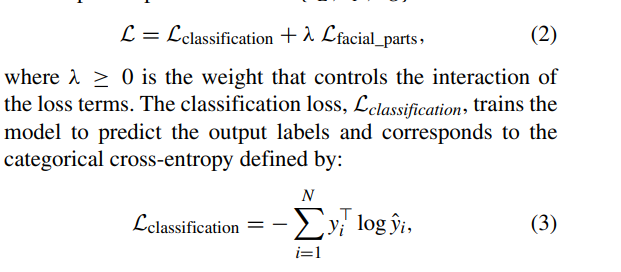

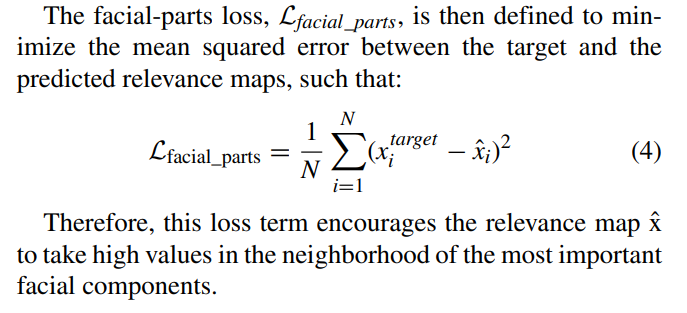

In [ ]:
def custom_L(y_true, y_pred, l = 0.5):
  y_pred_ = torch.sigmoid(y_pred)
  L_clf = - torch.mean( y_true*torch.log(y_pred_) + (1-y_true) * torch.log(1-y_pred_))
  L_fac_part = l* torch.mean((y_true - y_pred_)**2)

  return L_clf + L_fac_part

## Train / score / predict functions

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    train_losses = []
    val_losses = []
    val_metric = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
          # data to device
            X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  bce_loss(Y_batch, Y_pred)
            print("loss = ", loss)
            loss.backward()  # backward-pass
            opt.step()  # update weights
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss.detach().cpu().numpy().item() )
        model.eval()  # testing mode
        val_outp = model(X_val.to(DEVICE))
        val_loss = bce_loss(y= Y_val.detach().cpu(), y_pred = val_outp.detach().cpu())
        val_m = iou_pytorch(val_outp.detach().cpu(),  Y_val.detach().cpu())
        val_losses.append(val_loss.numpy().item())
        val_metric.append(np.mean(val_m.numpy()))
        Y_hat = Y_val.detach().cpu().numpy()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_losses, val_losses, val_metric

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch, Y_label = X_batch.to(device), Y_label.to(device)
        Y_pred = model(X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Train time !




Буду сохранять лоссы train/val и метрику iou на val в табличку на локальном гугл диске для каждой модели

кол-во эпох я везде оставила = 10, чтобы выборка для сравнения была одинакового размера

## Save function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
device = DEVICE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def records_of_train(train_losses, val_losses , val_metric, type_model_loss = '', \
                     path = '/content/drive/MyDrive/2023_DLS/1_part/Semantic_segmentation'):

  try:
    df = pd.read_csv(path+'/records_seg.csv')
    df["train_losses" + type_model_loss] = train_losses
    df["val_losses"+ type_model_loss] = val_losses
    df[ "val_metric" + type_model_loss] = val_metric
  except:
    df = pd.DataFrame({
        "train_losses" + type_model_loss: train_losses,
        "val_losses"+ type_model_loss : val_losses,
        "val_metric" + type_model_loss: val_metric,


    })

  df.to_csv(path + '/records_seg.csv')

## 1 - bce_loss

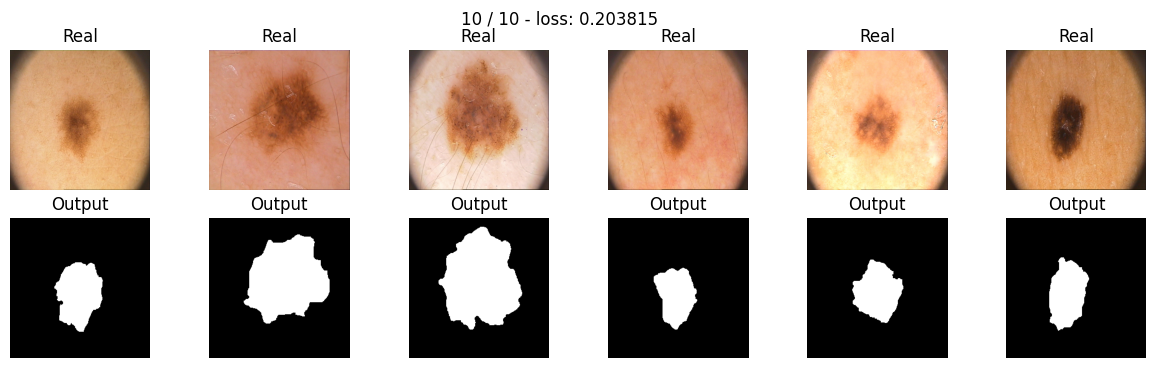

NameError: ignored

In [ ]:
model = SegNet().to(DEVICE)
max_epochs = 10
optim = torch.optim.Adam(model.parameters())
train_losses, val_losses , val_metric= train(model, optim, bce_loss, max_epochs, data_tr, data_val)


In [ ]:
records_of_train(train_losses, val_losses , val_metric, type_model_loss = 'SegNet_bce_loss')

In [ ]:
score_model(model, iou_pytorch, data_val)

0.27000000327825546

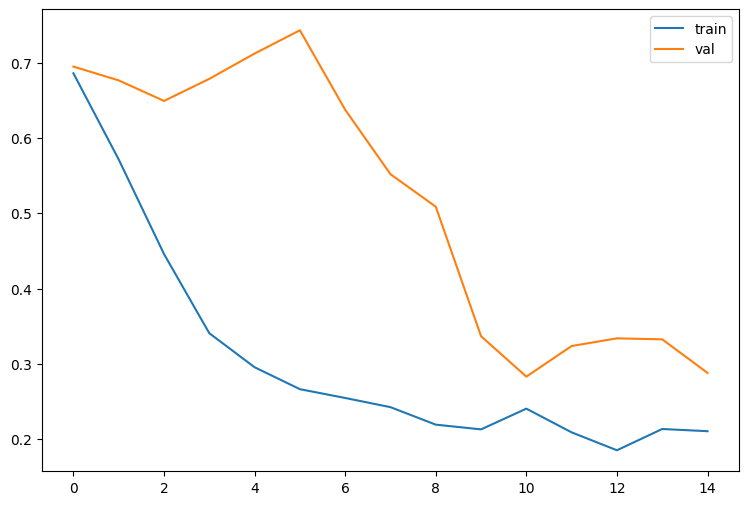

In [ ]:
from scipy.ndimage import label
def plot_loss(train_losses, val_losses):
    plt.figure(figsize = (9,6))
    plt.plot(train_losses, label="train" )
    plt.plot(val_losses, label="val")
    plt.legend()

plot_loss(train_losses, val_losses)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

## 2 -  dice_loss

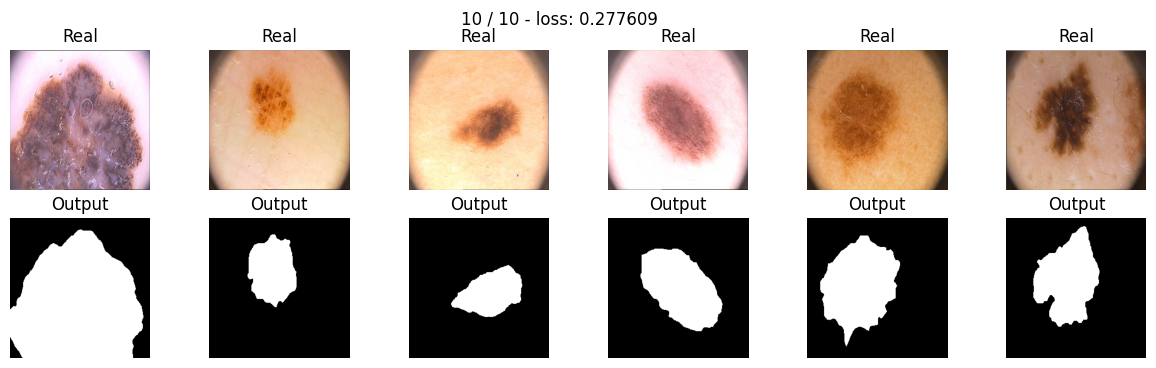

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 10
optimaizer = torch.optim.Adam(model_dice.parameters())
train_losses_dice, val_losses_dice, val_metric_dice =train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

records_of_train(train_losses_dice, val_losses_dice, val_metric_dice, type_model_loss = 'SegNet_dice_loss')

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.4879999905824661

Все итоговые графики отобразим в конце в отчёте

## 3 - focal_loss

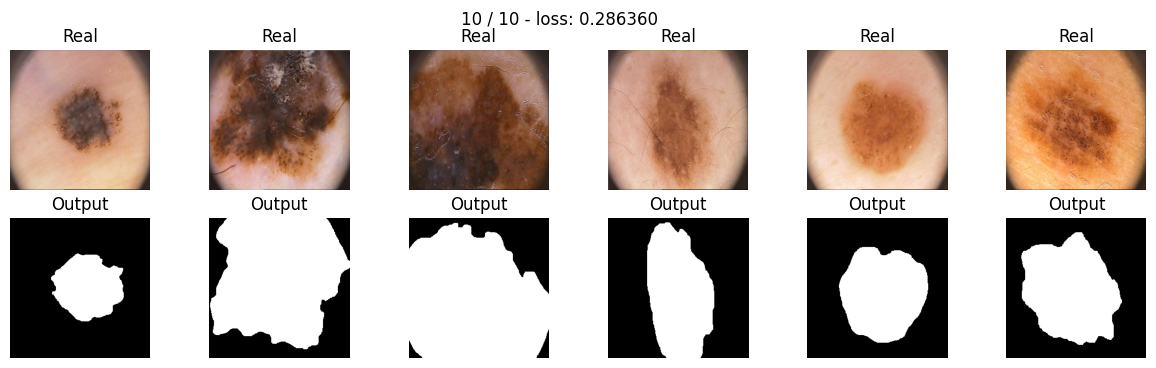

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 10
optimaizer = optim.Adam(model_focal.parameters())
train_losses_f, val_losses_f, val_metric_f = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'SegNet_focal_loss')

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.0

----------------------------------------------------------------------------------------------

## 4 - custom_loss



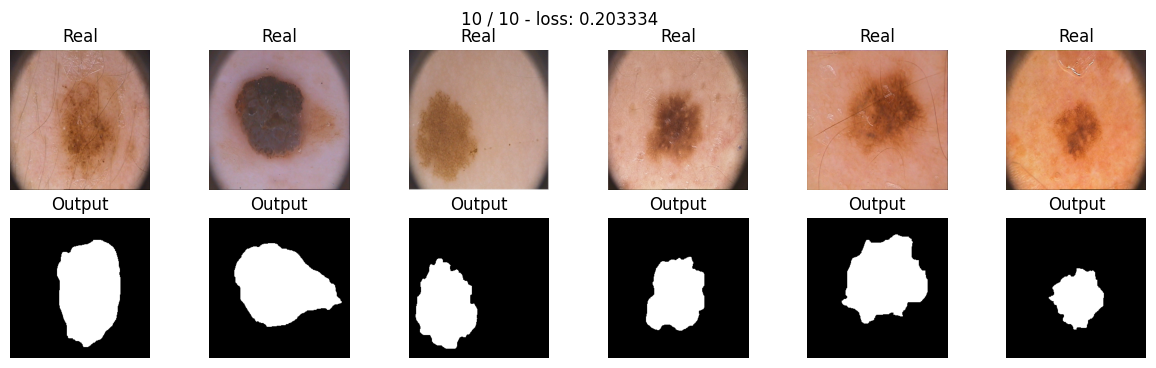

In [ ]:
model_custom_loss = SegNet().to(device)

max_epochs = 10
optim = torch.optim.Adam(model_custom_loss.parameters())
train_losses, val_losses, val_metric = train(model_custom_loss, optim, custom_L, max_epochs, data_tr, data_val)

records_of_train(train_losses, val_losses, val_metric, type_model_loss = 'SegNet_custom_loss')

In [ ]:
val_losses

[0.6875552535057068,
 0.6797950863838196,
 0.6634112596511841,
 0.6419132351875305,
 0.6791349649429321,
 0.7741301655769348,
 0.8114966750144958,
 0.8050732612609863,
 0.6657708883285522,
 0.5690407752990723]

In [ ]:
score_model(model_custom_loss, iou_pytorch, data_val)

0.2459999918937683

# Compare all losses

Сравним разные лоссы (на train/val) и метрики на их обучении

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2023_DLS/1_part/Semantic_segmentation/records_seg.csv')
df

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,train_lossesSegNet_bce_loss,val_lossesSegNet_bce_loss,val_metricSegNet_bce_loss,train_lossesSegNet_dice_loss,val_lossesSegNet_dice_loss,val_metricSegNet_dice_loss,train_lossesSegNet_focal_loss,val_lossesSegNet_focal_loss,val_metricSegNet_focal_loss,train_lossesSegNet_custom_loss,val_lossesSegNet_custom_loss,val_metricSegNet_custom_loss
0,0,0,0,0,0,0.691713,0.680795,0.000,0.684554,0.684396,0.000,0.713860,0.691091,0.0,0.690470,0.687555,0.000
1,1,1,1,1,1,0.594087,0.665924,0.000,0.632640,0.676926,0.000,0.647875,0.684062,0.0,0.632950,0.679795,0.000
2,2,2,2,2,2,0.463041,0.634414,0.000,0.572301,0.671131,0.000,0.599880,0.673545,0.0,0.560036,0.663411,0.000
3,3,3,3,3,3,0.382805,2.548671,0.092,0.491465,0.844634,0.000,0.568899,0.658822,0.0,0.414755,0.641913,0.000
4,4,4,4,4,4,0.300945,6.730549,0.092,0.393995,5.996361,0.000,0.453587,0.644041,0.0,0.305652,0.679135,0.000
5,5,5,5,5,5,0.268576,5.267656,0.092,0.363409,0.601762,0.000,0.390884,0.671634,0.0,0.276871,0.774130,0.000
6,6,6,6,6,6,0.226873,0.545055,0.088,0.346138,0.948906,0.144,0.326168,0.747345,0.0,0.235042,0.811497,0.008
7,7,7,7,7,7,0.204215,0.556677,0.160,0.322237,1.282241,0.240,0.295361,0.860120,0.0,0.231741,0.805073,0.012
8,8,8,8,8,8,0.190751,0.356302,0.332,0.302606,1.557378,0.420,0.269017,0.974467,0.0,0.205734,0.665771,0.128
9,9,9,9,9,9,0.203815,0.444111,0.336,0.277609,0.596895,0.484,0.286360,0.823297,0.0,0.203334,0.569041,0.264


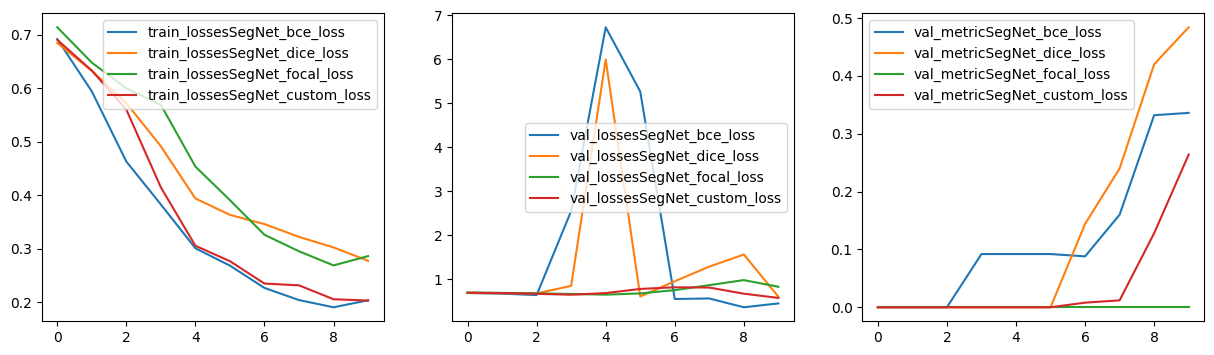

In [ ]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3)
ax1.plot(df['train_lossesSegNet_bce_loss'], label = 'train_lossesSegNet_bce_loss')
ax1.plot(df['train_lossesSegNet_dice_loss'], label = 'train_lossesSegNet_dice_loss')
ax1.plot(df['train_lossesSegNet_focal_loss'], label = 'train_lossesSegNet_focal_loss')
ax1.plot(df['train_lossesSegNet_custom_loss'], label = 'train_lossesSegNet_custom_loss')
ax1.legend()


ax2.plot(df['val_lossesSegNet_bce_loss'], label = 'val_lossesSegNet_bce_loss')
ax2.plot(df['val_lossesSegNet_dice_loss'], label = 'val_lossesSegNet_dice_loss')
ax2.plot(df['val_lossesSegNet_focal_loss'], label = 'val_lossesSegNet_focal_loss')
ax2.plot(df['val_lossesSegNet_custom_loss'], label = 'val_lossesSegNet_custom_loss')
ax2.legend()



ax3.plot(df['val_metricSegNet_bce_loss'], label = 'val_metricSegNet_bce_loss')
ax3.plot(df['val_metricSegNet_dice_loss'], label = 'val_metricSegNet_dice_loss')
ax3.plot(df['val_metricSegNet_focal_loss'], label = 'val_metricSegNet_focal_loss')
ax3.plot(df['val_metricSegNet_custom_loss'], label = 'val_metricSegNet_custom_loss')
ax3.legend()


**Для SegNet:**

* кастомный лосс и BCE лосс лучше себя показываю на train

* BCE loss хуже всех на valid. лучший - кастомный и focal

* быстрее всего на повышение метрики реагирует BCE loss

* лучшие метрики к концу обученя имеют BCE и Dice loss

----->> BCE loss показывает себя лучше

-----------------------------------------------------------------------------------------

# U-Net

https://arxiv.org/abs/1505.04597

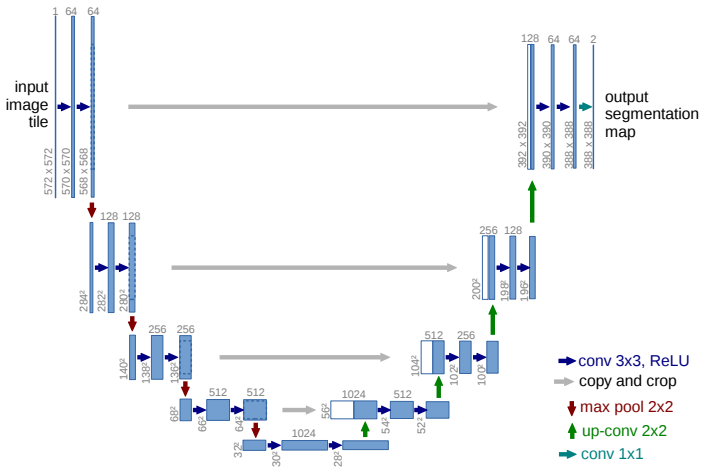

## Architecture - 1

Downsample with MaxPool

Upsample - nn.Upsample

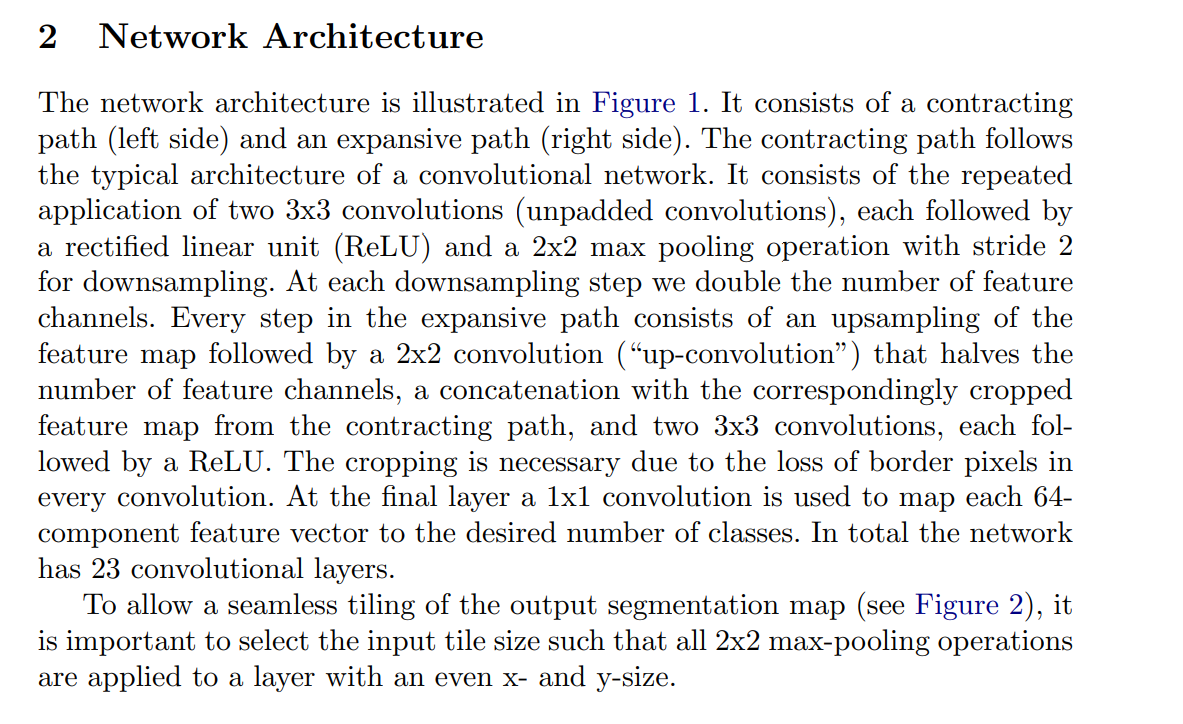

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.ReflectionPad2d(158), # Pads the input tensor using the reflection of the input boundary.
            nn.Conv2d(3, 64, (3, 3), padding=1 ),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d((3, 3), 2, padding=1)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d((3, 3), 2, padding=1) # nn.MaxPool2d((2, 2), 2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d((3, 3), 2, padding=1)  #  nn.MaxPool2d((2, 2), 2)
        self.enc_conv3 =  nn.Sequential(
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d((3, 3), 2, padding=1)  # nn.MaxPool2d((2, 2), 2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, (3, 3), padding=1),
            nn.ReLU()

        )

        # decoder (upsampling)
        self.upsample0 =  nn.Sequential(
            nn.Upsample(56) , # what size after enc_conv3 ?
            nn.Conv2d( 1024,512 , (3, 3), padding = 1)

        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU()

        )

        self.upsample1 =  nn.Sequential(
            nn.Upsample(104) ,
            nn.Conv2d( 512,256 , (3, 3), padding = 1)

        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU()

        )
        self.upsample2 =   nn.Sequential(
            nn.Upsample(200) ,
            nn.Conv2d( 256,128 , (3, 3), padding = 1)

        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU()

        )
        self.upsample3 =  nn.Sequential(
            nn.Upsample(392) ,
            nn.Conv2d( 128,64 , (3, 3), padding = 1)

        )
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, (3, 3)),

        )

    def forward(self, x):
        # encoder
        e0 =self.enc_conv0(x)
        e00 =  self.pool0(e0)

        e1 = self.enc_conv1(e00)
        e10 =  self.pool1(e1)

        e2 =  self.enc_conv2(e10)
        e20 = self.pool2(e2)

        e3 = self.enc_conv3(e20)
        e30 = self.pool3(e3)

        # bottleneck (UPSAMPLE -> RESIZE(=center_crop) e -> CAT -> CONCAT -> CONV)
        b = self.bottleneck_conv(e30)
        b0 = self.upsample0(b) # resize b0 to size of e3 output

        # decoder


        d00 = torch.cat((fn.center_crop(e3, output_size=[b0.shape[2]]), b0), dim = 1)
        d0 =  self.dec_conv0(d00)
        d111 = self.upsample1(d0)
        d11 = torch.cat((fn.center_crop(e2, output_size=[d111.shape[2]]), d111), dim = 1)
        d1 = self.dec_conv1(d11)
        d222 = self.upsample2(d1)
        d22 = torch.cat((fn.center_crop(e1, output_size=[d222.shape[2]]), d222), dim = 1)
        d2 = self.dec_conv2(d22)
        d333 = self.upsample3(d2)
        d33 = torch.cat((fn.center_crop(e0, output_size=[d333.shape[2]]), d333), dim = 1)
        d3 = self.dec_conv3(d33)  # no activation
        d3 = fn.center_crop(d3, output_size=[256])
        return d3




### Train with different losses

In [ ]:
# перепишем train (под батч = 4) - уберу визуализацию картинок

def train(model, opt, loss_fn, epochs, data_tr, data_val):

    train_losses = []
    val_losses = []
    val_metric = []

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
          # data to device
            X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss =  bce_loss(Y_batch, Y_pred)
            print("loss = ", loss)

            loss.backward()  # backward-pass
            opt.step()  # update weights

            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss.detach().cpu().numpy().item() )
        model.eval()  # testing mode
        val_outp = model(X_val.to(DEVICE))
        val_loss = bce_loss(y= Y_val.detach().cpu(), y_pred = val_outp.detach().cpu())
        val_m = iou_pytorch(val_outp.detach().cpu(),  Y_val.detach().cpu())
        val_losses.append(val_loss.numpy().item())
        val_metric.append(np.mean(val_m.numpy()))
        Y_hat = Y_val.detach().cpu().numpy() # detach and put into cpu


    return train_losses, val_losses, val_metric

In [ ]:
torch.cuda.empty_cache()
unet_model = UNet().to(device)
max_epochs = 10
optimaizer = optim.Adam(unet_model.parameters())
train_losses_f, val_losses_f, val_metric_f = train( unet_model, optimaizer, focal_loss, max_epochs, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_focal_loss')
# --done

In [ ]:
torch.cuda.empty_cache()
unet_model = UNet().to(device)
max_epochs = 10
optimaizer = optim.Adam(unet_model.parameters())

train_losses_f, val_losses_f, val_metric_f = train(unet_model, optimaizer, custom_L, max_epochs, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_custom_L_loss')
# --done

In [ ]:
torch.cuda.empty_cache()
unet_model = UNet().to(device)
max_epochs = 10
optimaizer = optim.Adam(unet_model.parameters())

train_losses_f, val_losses_f, val_metric_f = train(unet_model, optimaizer, dice_loss, max_epochs, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_dice_loss')
# --done

In [ ]:
torch.cuda.empty_cache()
unet_model = UNet().to(device)
max_epochs = 10
optimaizer = optim.Adam(unet_model.parameters())

train_losses_f, val_losses_f, val_metric_f = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_bce_loss')

# --done

### Save results

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2023_DLS/1_part/Semantic_segmentation/records_seg.csv')
df.columns

Index(['Unnamed: 0.9', 'Unnamed: 0.8', 'Unnamed: 0.7', 'Unnamed: 0.6',
       'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'Unnamed: 0', 'train_lossesSegNet_bce_loss',
       'val_lossesSegNet_bce_loss', 'val_metricSegNet_bce_loss',
       'train_lossesSegNet_dice_loss', 'val_lossesSegNet_dice_loss',
       'val_metricSegNet_dice_loss', 'train_lossesSegNet_focal_loss',
       'val_lossesSegNet_focal_loss', 'val_metricSegNet_focal_loss',
       'train_lossesSegNet_custom_loss', 'val_lossesSegNet_custom_loss',
       'val_metricSegNet_custom_loss', 'train_lossesUNet_focal_loss',
       'val_lossesUNet_focal_loss', 'val_metricUNet_focal_loss',
       'train_lossesUNet_custom_L_loss', 'val_lossesUNet_custom_L_loss',
       'val_metricUNet_custom_L_loss', 'train_lossesUNet_dice_loss',
       'val_lossesUNet_dice_loss', 'val_metricUNet_dice_loss',
       'train_lossesUNet_bce_loss', 'val_lossesUNet_bce_loss',
       'val_metricUNet_bce_loss'],
      

### Compare loss plots

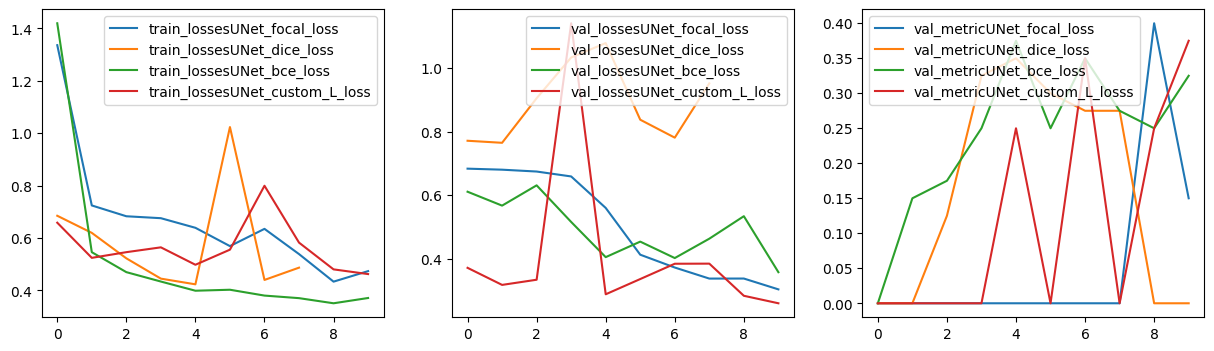

In [ ]:


fig, (ax1, ax2, ax3)  = plt.subplots(1, 3)
ax1.plot(df['train_lossesUNet_focal_loss'], label = 'train_lossesUNet_focal_loss')
ax1.plot(df['train_lossesUNet_dice_loss'], label = 'train_lossesUNet_dice_loss')
ax1.plot(df['train_lossesUNet_bce_loss'], label = 'train_lossesUNet_bce_loss')
ax1.plot(df['train_lossesUNet_custom_L_loss'], label = 'train_lossesUNet_custom_L_loss')
ax1.legend()


ax2.plot(df['val_lossesUNet_focal_loss'], label = 'val_lossesUNet_focal_loss')
ax2.plot(df['val_lossesUNet_dice_loss'], label = 'val_lossesUNet_dice_loss')
ax2.plot(df['val_lossesUNet_bce_loss'], label = 'val_lossesUNet_bce_loss')
ax2.plot(df['val_lossesUNet_custom_L_loss'], label = 'val_lossesUNet_custom_L_loss')
ax2.legend()



ax3.plot(df['val_metricUNet_focal_loss'], label = 'val_metricUNet_focal_loss')
ax3.plot(df['val_metricUNet_dice_loss'], label = 'val_metricUNet_dice_loss')
ax3.plot(df['val_metricUNet_bce_loss'], label = 'val_metricUNet_bce_loss')
ax3.plot(df['val_metricUNet_custom_L_loss'], label = 'val_metricUNet_custom_L_losss')
ax3.legend()
#plt.suptitle('SegNet')

**Для U-Net:**

* dice loss хуже и на train и на val

*  на train - лучший BCE , кастомный и focal к концу обучения ведут себя похоже

* на val кастомный и focal к концу обучения ведут себя похоже - лучше всех

* лучше всего на метрике показывает себя кастомный и BCE

----->> тут кастомный и BCE - лучший выбор

## Architecture - 2

Downsample with no MaxPool, only Conv layers

Upsample - ConvTranspose2d

In [ ]:
import torchvision.transforms.functional as fn
from torchvision.transforms import CenterCrop

class UNet2(nn.Module):

    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.ReflectionPad2d(158), # Pads the input tensor using the reflection of the input boundary.
            nn.Conv2d(3, 64, (3, 3), padding=1 ),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.ReLU()
        )

        self.pool0 = nn.Conv2d(64, 64, (3, 3), stride = 2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, (3, 3), stride = 2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool2 =nn.Conv2d(256, 256, (3, 3), stride = 2)
        self.enc_conv3 =  nn.Sequential(
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, (3, 3), stride = 2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, (3, 3), padding=1),
            nn.ReLU()

        )

        # decoder (upsampling)
        self.upsample0 =  nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, (3, 3), 2), # nn.Upsample(56) ,
            nn.Conv2d( 1024,512 , (3, 3), padding = 1)

        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU()

        )

        self.upsample1 =  nn.Sequential(
             nn.ConvTranspose2d(512, 512, (3, 3), 2) , #nn.Upsample(104) ,
            nn.Conv2d( 512,256 , (3, 3), padding = 1)

        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU()

        )
        self.upsample2 =   nn.Sequential(
             nn.ConvTranspose2d(256, 256, (3, 3), 2), #nn.Upsample(200) ,
            nn.Conv2d( 256,128 , (3, 3), padding = 1)

        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU()

        )
        self.upsample3 =  nn.Sequential(
             nn.ConvTranspose2d(128, 128, (3, 3), 2), #nn.Upsample(392) ,
            nn.Conv2d( 128,64 , (3, 3), padding = 1)

        )
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, (3, 3)),

        )

    def forward(self, x):


        # encoder
        e0 =self.enc_conv0(x)
        e00 =  self.pool0(e0)

        e1 = self.enc_conv1(e00)
        e10 =  self.pool1(e1)

        e2 =  self.enc_conv2(e10)
        e20 = self.pool2(e2)

        e3 = self.enc_conv3(e20)

        e30 = self.pool3(e3)
        b = self.bottleneck_conv(e30)
        b0 = self.upsample0(b) # resize b0 to size of e3 output
        # decoder


        d00 = torch.cat((fn.center_crop(e3, output_size=[b0.shape[2]]), b0), dim = 1)
        d0 =  self.dec_conv0(d00)

        d111 = self.upsample1(d0)
        d11 = torch.cat((fn.center_crop(e2, output_size=[d111.shape[2]]), d111), dim = 1)
        d1 = self.dec_conv1(d11)

        d222 = self.upsample2(d1)
        d22 = torch.cat((fn.center_crop(e1, output_size=[d222.shape[2]]), d222), dim = 1)
        d2 = self.dec_conv2(d22)

        d333 = self.upsample3(d2)
        d33 = torch.cat((fn.center_crop(e0, output_size=[d333.shape[2]]), d333), dim = 1)
        d3 = self.dec_conv3(d33)  # no activation
        d3 = fn.center_crop(d3, output_size=[256])
        return d3




### Train time !

In [ ]:
torch.cuda.empty_cache()
unet2_model = UNet2().to(device)
train_losses_f, val_losses_f, val_metric_f  = train(unet2_model, optim.Adam(unet2_model.parameters(), lr = 1e-4 ), dice_loss, 10, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_2_dice_loss')
# -- done

In [ ]:
torch.cuda.empty_cache()
unet2_model = UNet2().to(device)

train_losses_f, val_losses_f, val_metric_f  = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 10, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_2_bce_loss')

# -- done

In [ ]:
torch.cuda.empty_cache()
unet2_model = UNet2().to(device)
train_losses_f, val_losses_f, val_metric_f  = train(unet2_model, optim.Adam(unet2_model.parameters(), lr = 0.0001), focal_loss, 10, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_2_focal_loss')
# -- done

In [ ]:

torch.cuda.empty_cache()
unet2_model = UNet2().to(device)
train_losses_f, val_losses_f, val_metric_f  = train(unet2_model, optim.Adam(unet2_model.parameters(), lr = 0.0001), custom_L, 10, data_tr, data_val)
records_of_train(train_losses_f, val_losses_f, val_metric_f , type_model_loss = 'UNet_2_custom_L')
# -- done

### Save / display results

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2023_DLS/1_part/Semantic_segmentation/records_seg.csv')

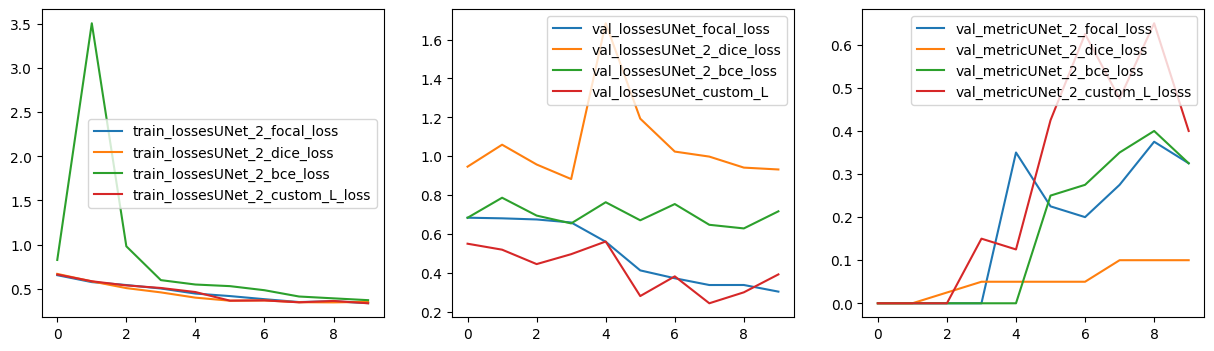

In [ ]:

fig, (ax1, ax2, ax3)  = plt.subplots(1, 3)
ax1.plot(df['train_lossesUNet_2_focal_loss'], label = 'train_lossesUNet_2_focal_loss')
ax1.plot(df['train_lossesUNet_2_dice_loss'], label = 'train_lossesUNet_2_dice_loss')
ax1.plot(df['train_lossesUNet_2_bce_loss'], label = 'train_lossesUNet_2_bce_loss')
ax1.plot(df['train_lossesUNet_2_custom_L'], label = 'train_lossesUNet_2_custom_L_loss')
ax1.legend()


ax2.plot(df['val_lossesUNet_focal_loss'], label = 'val_lossesUNet_focal_loss')
ax2.plot(df['val_lossesUNet_2_dice_loss'], label = 'val_lossesUNet_2_dice_loss')
ax2.plot(df['val_lossesUNet_2_bce_loss'], label = 'val_lossesUNet_2_bce_loss')
ax2.plot(df['val_lossesUNet_2_custom_L'], label = 'val_lossesUNet_custom_L')
ax2.legend()



ax3.plot(df['val_metricUNet_2_focal_loss'], label = 'val_metricUNet_2_focal_loss')
ax3.plot(df['val_metricUNet_2_dice_loss'], label = 'val_metricUNet_2_dice_loss')
ax3.plot(df['val_metricUNet_2_bce_loss'], label = 'val_metricUNet_2_bce_loss')
ax3.plot(df['val_metricUNet_2_custom_L'], label = 'val_metricUNet_2_custom_L_losss')
ax3.legend()

#plt.suptitle('SegNet')

**Для U-Net-2:**

* все лоссы на train ведут себя +- похожу, нел лучшего или худшего

* лучшие лоссы на valid - кастомный и focal

* кастомный лосс показывает лучшую метрику

----->> кастомный лосс лучше

## Compare two U-nets

Сравнили лоссы и метрики внутри моделей, теперь сравним сами модели по метрикам

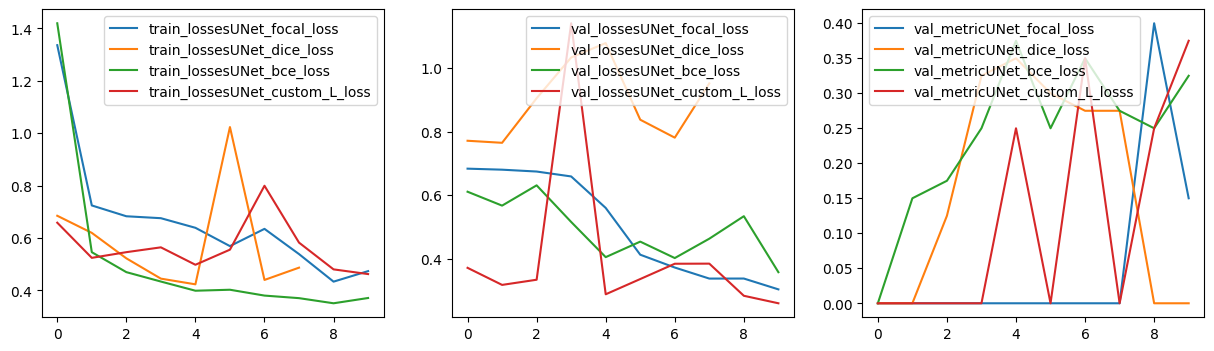

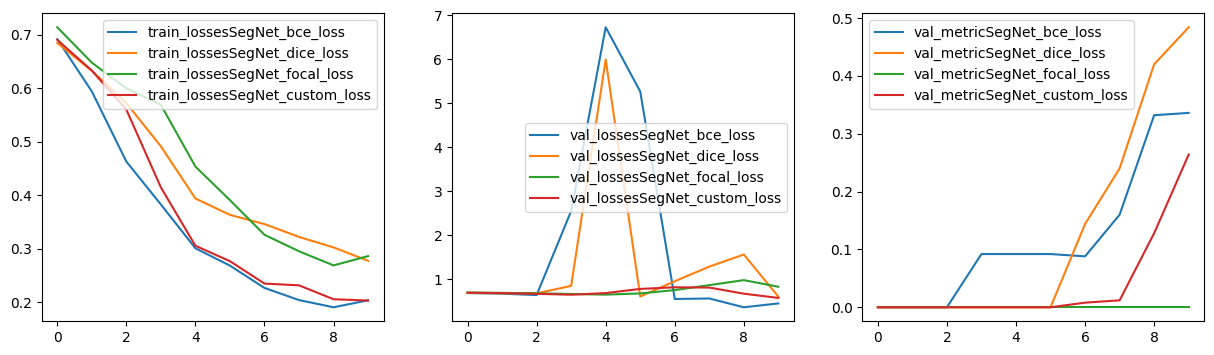

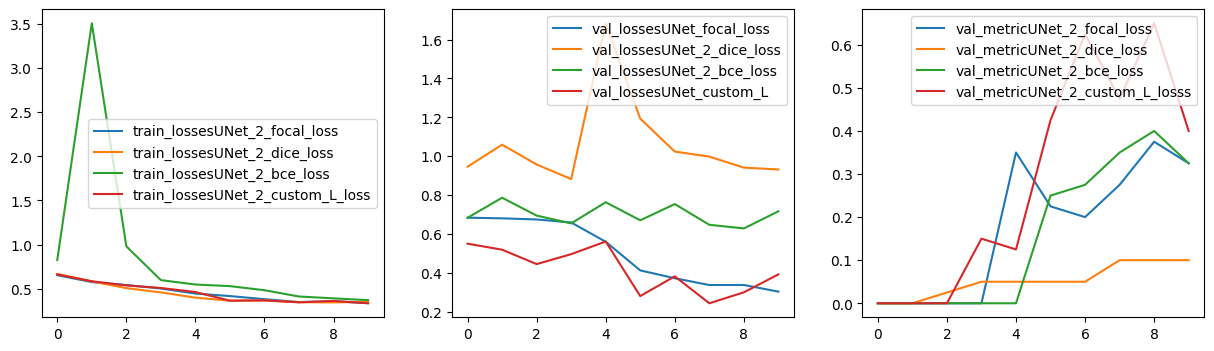

* U-net-2  показывает лучшие метрики, немного лучше чем SegNet

* у U-Net-2  рост метрики начинается раньше чем у SegNet


--->> лучшая архитектура -  U-net-2 с кастомным лоссом